In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import scipy.misc as misc
from skimage.transform import resize as imresize

In [2]:
from src.autoencodernet import StyleAutoEncoder

In [3]:
tf.reset_default_graph()


tfx = tf.layers.Input(shape=(256, 256, 3))
tfxrec = StyleAutoEncoder(tfx)


loss = tf.nn.l2_loss(tfx - tfxrec.output)#/(256*256*3)
train = tf.train.AdamOptimizer(0.1).minimize(loss)


sess = tf.Session()
init = tf.global_variables_initializer()
sess.run(init)

In [4]:
with sess.as_default():
    nptfx = sess.run(tfxrec.output, feed_dict={tfx: 255 * np.random.random([1, 256, 256, 3])})

In [5]:
nptfx.shape

(1, 256, 256, 3)

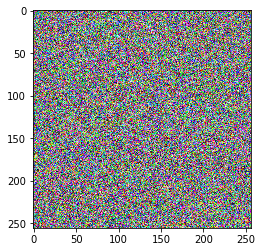

In [6]:
plt.imshow(nptfx[0])

In [7]:
print(nptfx.min(), nptfx.max())

0.3569894 254.49883


In [243]:
def imread(path):
    return imresize(plt.imread(path).astype(np.float32)/255, (244, 244), mode='reflect')

def imbatch1(img):
    return np.expand_dims(img, axis=0)

In [244]:
img = imread('/home/diogo/data/deep_studies/style_transfer/night.jpeg')

0.0 0.9416451275292286


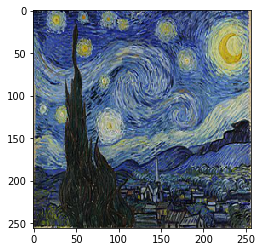

In [10]:
print(img.min(), img.max())
plt.imshow(img)

In [11]:
ll = []

In [15]:
import os
files = os.listdir('/home/diogo/data/deep_studies/style_transfer/fast-style-transfer/data/train2014')

def plot_img_cmp(X, Xt, nimages=10):
    imgidxs = np.random.choice(X.shape[0], nimages)

    fig, axeslist = plt.subplots(ncols=nimages, nrows=2, sharex=True, sharey=True)
    fig.set_size_inches(16, 8)
    #fig.subplots_adjust(left=0, bottom=0, right=1, top=0.1, wspace=0, hspace=0)
    
    for i in range(nimages):
        axeslist[0, i].imshow(X[imgidxs[i]])
        axeslist[0, i].set_axis_off()
        
        axeslist[1, i].imshow(Xt[imgidxs[i]])
        axeslist[1, i].set_axis_off()

    fig.subplots_adjust(wspace=0, hspace=-0.7)

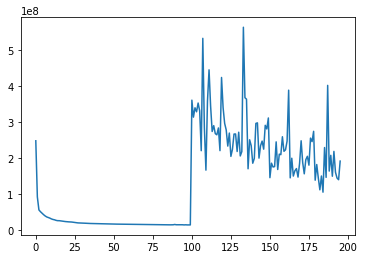

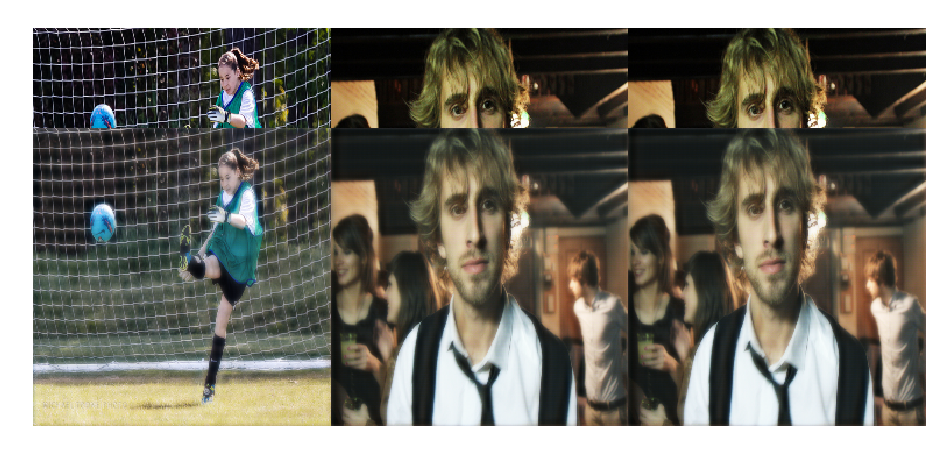

In [20]:
%matplotlib inline
from IPython.display import display, clear_output
base = '/home/diogo/data/deep_studies/style_transfer/fast-style-transfer/data/train2014/'

food = {tfx: 255*imbatch1(img)}
with sess.as_default():
    for i in range(50):
        npimages = np.asarray([255 * imread(base + x) for x in np.random.choice(files, 5)], dtype=np.float32)
        food = {tfx: npimages}
        l, _ = sess.run([loss, train], feed_dict=food)
        ll.append(l)
        if i % 5 == 0 and i > 0:
            imgt = sess.run(tfxrec.output, feed_dict=food)
            imgt = imgt
            #imgt = np.squeeze(imgt, 0)
            #clear_output()
            #plt.ioff()
            #_ll = ll[:min(len(ll), 200)]
            #plt.plot(np.arange(len(_ll)), _ll)
            plt.plot(np.arange(len(ll)), ll)
            plt.show()
            
            #plot_img_random(Xt)
            plot_img_cmp(npimages/255, imgt/255, 3)
            #plt.imshow(imgt/255)
            plt.show()
            clear_output(wait=True)
        


In [ ]:
print(imgt.min(), imgt.max())

In [ ]:
len(files)

In [ ]:
X =  np.asarray([255 * imread('/home/diogo/data/deep_studies/style_transfer/fast-style-transfer/data/train2014/' + x) for x in np.random.choice(files, 10)], dtype=np.float32)

fig, axeslist = plt.subplots(ncols=5, nrows=1, sharey=True)
for i in range(5):
    fig.set_size_inches(14, 3)
    axeslist.ravel()[i].imshow(X[i]/255)
    axeslist.ravel()[i].axis('off')


In [ ]:
plt.imshow(X[1]/255)

In [ ]:
X.shape

In [ ]:
def need_input(layer):
    def new_function(s, *args, **kwargs):
        original_function(*args, **kwargs)
        print("Hello, galaxy!")
    return new_function

In [21]:
tf.reset_default_graph()

In [22]:
import numpy as np
from scipy.io import loadmat as load_from_matlab


In [23]:
data = load_from_matlab('/home/diogo/data/deep_studies/style_transfer/imagenet-vgg-verydeep-19.mat')

In [42]:
weights = data['layers'][0]

In [142]:
weights[37][0][0][0][0][0].shape

(7, 7, 512, 4096)

In [ ]:

tf.reset_default_graph()

STRIDE1 = (1, 1, 1, 1)

def conv(data, filters, size, inputs):
    W, B = data[0][0][0][0]
    T, H, Ci, C = inputs.shape
    
    assert W.shape == (size, size, C, filters)
    assert B.shape == (1, filters)
    assert C == W.shape[2]
    
    print('OK!')
    
    W = W.transpose((1, 0, 2, 3))
    B = B.reshape(-1)


    tfW = tf.constant(W)
    tfB = tf.constant(B)

    _conv = tf.nn.conv2d(inputs, tfW, STRIDE1, 'SAME') + tfB
    print(inputs.shape, '->', _conv.shape)
    return _conv

def relu(data, inputs):
    assert data[0][0][0][0] == 'relu'
    print('OK!')
    return tf.nn.relu(inputs)

def maxpool(data, inputs):
    assert 'pool' in data[0][0][0][0]
    
    _l = tf.layers.max_pooling2d(inputs, 2, 2, padding='VALID')
    
    print(inputs.shape, '->', _l.shape)
    return _l


def flatten(data, inputs):
    W, B = data[0][0][0][0]
    Tx, Hx, Wx, Cx = inputs.shape
    WH, WW, Wi, Wo = W.shape

    print(inputs.shape, W.shape, B.shape)
    
    assert (WH, WH, Wi) == (Hx, Wx, Cx)
    print('OK!')
    return tf.layers.flatten(inputs)


def dense(data, x):
    W, B = data[0][0][0][0]
    WH, WH, Wi, Wo = W.shape
    W = W.reshape([-1, Wo])
    
    I, O = W.shape

    assert B.shape == (1, Wo)
    
    T, L = x.shape
    
    assert L == I
    print('OK!')
    return tf.matmul(x, W) + B
    
def softmax(data, x):
    assert 'softmax' == data[0][0][0][0]
    print('OK!')
    return tf.nn.softmax(x)


tf_input_image = tf.placeholder(shape=[1, 244, 244, 3], dtype=tf.float32)

x = conv(weights[0], 64, 3, tf_input_image)
x = relu(weights[1], x)
x = conv(weights[2], 64, 3, x)
x = relu(weights[3], x)
x = maxpool(weights[4], x)

x = conv(weights[5], 128, 3, x)
x = relu(weights[6], x)
x = conv(weights[7], 128, 3, x)
x = relu(weights[8], x)
x = maxpool(weights[9], x)

x = conv(weights[10], 256, 3, x)
x = relu(weights[11], x)
x = conv(weights[12], 256, 3, x)
x = relu(weights[13], x)
x = conv(weights[14], 256, 3, x)
x = relu(weights[15], x)
x = conv(weights[16], 256, 3, x)
x = relu(weights[17], x)
x = maxpool(weights[18], x)

x = conv(weights[19], 512, 3, x)
x = relu(weights[20], x)
x = conv(weights[21], 512, 3, x)
x = relu(weights[22], x)
x = conv(weights[23], 512, 3, x)
x = relu(weights[24], x)
x = conv(weights[25], 512, 3, x)
x = relu(weights[26], x)
x = maxpool(weights[27], x)

x = conv(weights[28], 512, 3, x)
x = relu(weights[29], x)
x = conv(weights[30], 512, 3, x)
x = relu(weights[31], x)
x = conv(weights[32], 512, 3, x)
x = relu(weights[33], x)
x = conv(weights[34], 512, 3, x)
x = relu(weights[35], x)
x = maxpool(weights[36], x)

x = flatten(weights[37], x)
x = dense(weights[37], x)
x = relu(weights[38], x)
x = dense(weights[39], x)
x = relu(weights[40], x)
x = dense(weights[41], x)
tf_output_classes = softmax(weights[42], x)

assert x.shape == (1, 1000)

sess = tf.Session()
init = tf.global_variables_initializer()
sess.run(init)

OK!
(1, 244, 244, 3) -> (1, 244, 244, 64)
OK!
OK!
(1, 244, 244, 64) -> (1, 244, 244, 64)
OK!
(1, 244, 244, 64) -> (1, 122, 122, 64)
OK!
(1, 122, 122, 64) -> (1, 122, 122, 128)
OK!
OK!
(1, 122, 122, 128) -> (1, 122, 122, 128)
OK!
(1, 122, 122, 128) -> (1, 61, 61, 128)
OK!
(1, 61, 61, 128) -> (1, 61, 61, 256)
OK!
OK!
(1, 61, 61, 256) -> (1, 61, 61, 256)
OK!
OK!
(1, 61, 61, 256) -> (1, 61, 61, 256)
OK!
OK!
(1, 61, 61, 256) -> (1, 61, 61, 256)
OK!
(1, 61, 61, 256) -> (1, 30, 30, 256)
OK!
(1, 30, 30, 256) -> (1, 30, 30, 512)
OK!
OK!
(1, 30, 30, 512) -> (1, 30, 30, 512)
OK!
OK!
(1, 30, 30, 512) -> (1, 30, 30, 512)
OK!
OK!
(1, 30, 30, 512) -> (1, 30, 30, 512)
OK!
(1, 30, 30, 512) -> (1, 15, 15, 512)
OK!
(1, 15, 15, 512) -> (1, 15, 15, 512)
OK!
OK!
(1, 15, 15, 512) -> (1, 15, 15, 512)
OK!
OK!
(1, 15, 15, 512) -> (1, 15, 15, 512)
OK!
OK!
(1, 15, 15, 512) -> (1, 15, 15, 512)
OK!
(1, 15, 15, 512) -> (1, 7, 7, 512)
(1, 7, 7, 512) (7, 7, 512, 4096) (1, 4096)
OK!
OK!
OK!
OK!
OK!
OK!
OK!


In [263]:
img = imread('/home/diogo/data/deep_studies/style_transfer/tusker.jpeg')
#plt.imshow(img)
imgbt = imbatch1(img)
#print(imgbt.min(), imgbt.max(), imgbt.shape)

imgbt = imgbt[:, :, :, (2, 1, 0)] - np.asarray([103.939, 116.779, 123.68])/255
#print(imgbt.min(), imgbt.max(), imgbt.shape)


#imgbt = imgbt[(0, 3, 2, 1) ] - np.asarray([103.939, 116.779, 123.68])/255

print(type(imgbt), type(tf_output_classes), type(tf_input_image))

#with sess.as_default():
#    npclasses = sess.run(tf_output_classes, feed_dict={tf_input_image:imgbt})

<class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'tensorflow.python.framework.ops.Tensor'>


In [252]:
imgbt

array([-0.22435108, -0.27470402, -0.30176676])

In [134]:
W = np.zeros((7, 7, 512, 4096))

In [145]:
W, B = weights[37][0][0][0][0]

In [147]:
W.shape

(7, 7, 512, 4096)

In [203]:
data['normalization']

array([[(array([[[123.68 , 116.779, 103.939],
        [123.68 , 116.779, 103.939],
        [123.68 , 116.779, 103.939],
        ...,
        [123.68 , 116.779, 103.939],
        [123.68 , 116.779, 103.939],
        [123.68 , 116.779, 103.939]],

       [[123.68 , 116.779, 103.939],
        [123.68 , 116.779, 103.939],
        [123.68 , 116.779, 103.939],
        ...,
        [123.68 , 116.779, 103.939],
        [123.68 , 116.779, 103.939],
        [123.68 , 116.779, 103.939]],

       [[123.68 , 116.779, 103.939],
        [123.68 , 116.779, 103.939],
        [123.68 , 116.779, 103.939],
        ...,
        [123.68 , 116.779, 103.939],
        [123.68 , 116.779, 103.939],
        [123.68 , 116.779, 103.939]],

       ...,

       [[123.68 , 116.779, 103.939],
        [123.68 , 116.779, 103.939],
        [123.68 , 116.779, 103.939],
        ...,
        [123.68 , 116.779, 103.939],
        [123.68 , 116.779, 103.939],
        [123.68 , 116.779, 103.939]],

       [[123.68 , 116.779, 103

In [235]:
def read_classes(data):
    idxs, names = data['classes'][0, 0]
    idxs = idxs[0]
    names = names[0]
    fname = [n[0].split(',')[0] for n in names]
    
    return fname, names, idxs, 

name, _, _, = read_classes(data)


In [236]:
name[100]

'black swan'

In [231]:
names[0]

array(['tench, Tinca tinca'], dtype='<U18')

In [239]:
#RGB -> BGR
#(0, 1, 2) -> (2, 1, 0) 

np.asarray([103.939, 116.779, 123.68])/255

array([0.40760392, 0.45795686, 0.48501961])